In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import glob
import os
import math as m
import numpy as np
import warnings

# Read data from A_xvgs and B_xvgs list 
def read_data(A_xvgs, B_xvgs, alpha, hij, dl):   
    #constant
    joule_to_cal: float = 0.239001

    frames=len(A_xvgs)
    df_potentialA0 = pd.read_csv(A_xvgs[0], comment="@", delimiter="\s+", header=13)
    N = df_potentialA0.shape[0] # no. of energy points per frame  # no. of energy points per frame
    # frames, [sysA, sysB, de, V(l), evb, e1-V(l), e2-V(l)], evb-V(l)
    feps = np.zeros(shape =(frames,8,N))
    
    for i in range(len(A_xvgs)):
        lambda_value = int(re.sub(r"\D", " ", os.path.basename(A_xvgs[i])[0:2]))
        df_potentialA = pd.read_csv(A_xvgs[i], comment="@", delimiter="\s+", header=13)

    
        #  Condition: to make sure the xvg file in potentialA and potentialB subfolder belong to same lambda value
        if lambda_value == int(re.sub(r"\D", " ", os.path.basename(B_xvgs[i])[0:2])):
            #print("lambda is", lambda_value)
            df_potentialB = pd.read_csv(B_xvgs[i], comment="@", delimiter="\s+", header=13)

            feps[lambda_value][0][:] = joule_to_cal*df_potentialA.iloc[:, 1].to_numpy()  # sysA
            feps[lambda_value][1][:] = joule_to_cal*df_potentialB.iloc[:, 1].to_numpy()  # sysB
        else:
            print("xvg in potentialA mismatch xvg in potentialB ")

            
    for i in range(frames):
        for j in range(N):
            feps[i][2][j] = (feps[i][0][j] - feps[i][1][j] - alpha) # e1-e2
            feps[i][3][j] = (1-i*dl)*(feps[i][0][j]) +\
                            (i*dl)*(feps[i][1][j] + alpha) # V(l)
            
            feps[i][4][j] = 0.5 * (feps[i][0][j] + feps[i][1][j] + alpha) -\
                            0.5 * m.sqrt((feps[i][2][j])**2 + 4 * hij ** 2) # evb
            
            feps[i][5][j] = (feps[i][0][j] ) - feps[i][3][j] # e1-V(l)
            feps[i][6][j] = (feps[i][1][j]  + alpha) - feps[i][3][j] # e2-V(l)
            feps[i][7][j] = feps[i][4][j] - feps[i][3][j] # evb-V(l)

    return feps, N

In [34]:
## dG(lambda)
def gofl(feps, frames, N, kT, dl):
    dgf = [] # G(l) forward
    dgb = [] # G(l) backward
    dg_lambda = [0]
    
    for i in range(frames-1):  # '-1' because forward and backward
        with warnings.catch_warnings():
            warnings.filterwarnings('error')
            try:
                dgf.append(-kT * m.log(np.exp(feps[i][2] * dl / kT).sum()) + kT * m.log(N))  # exp(-(e2-e1)*dl/kT) because dl is negative
            except RuntimeWarning:
                print(f"Value out of numpy.exp() domain for e1-e2 in frame {i}")
                sys.exit()
            except ValueError:
                print(f"{np.exp(feps[i][2] * dl / kT).sum()} is out of math.log() domain for sum(e1-e2) at RS")
                sys.exit()
            try:
                dgb.append(kT * m.log(np.exp(-feps[i+1][2] * dl / kT).sum()) - kT * m.log(N))
            except RuntimeWarning:
                print(f"Value out of numpy.exp() domain for e1-e2 in frame {i+1}")
                sys.exit()
            except ValueError:
                print(f"{np.exp(-feps[i+1][2] * dl / kT).sum()} is out of math.log() domain for sum(e1-e2) at RS")
                sys.exit()
        dg_lambda.append(dg_lambda[-1] + 0.5 * (dgf[i] + dgb[i]))

    # FEP coordinate (lambda)
    lc = [dl*i for i in range(frames)]
    lc.reverse()

    return dg_lambda, lc


# e1-e2 gaps
def gaps(feps, bins):
    min_gaps = []
    max_gaps = []
    for i in range(feps.shape[0]):
        min_gaps.append(feps[i][2].min())
        max_gaps.append(feps[i][2].max())
        
    min_gap = min(min_gaps)
    max_gap = max(max_gaps)
    
    dgap = (max_gap - min_gap)/(bins)
    
    # Xs = e1 - e2
    x = [min_gap]
    for i in range(bins):
        x.append(x[-1]+dgap)
    
    return x


# arrange data per lambda per bin
def uofx(feps, bins, x, frames):
    free_en = []
    for nbin in range(bins):
        free_en.append([])
        for frame in range(frames):
            free_en[nbin].append([[], [], []]) # e1-V(l), e2-V(l), Eg-V(l)
    
    for frame in range(frames): # run over the two gaps
        for jj, j in enumerate(feps[frame][2]):
            for nbin in range(bins-1):
                if nbin == 0:
                    if  x[nbin] <= j <= x[nbin+1]:
                        free_en[nbin][frame][0].append(feps[frame][5][jj]) # e1-V(l)
                        free_en[nbin][frame][1].append(feps[frame][6][jj]) # e2-V(l)
                        free_en[nbin][frame][2].append(feps[frame][7][jj]) # eg-V(l)
                        break
                else:
                    if  x[nbin] < j <= x[nbin+1]+1:
                        free_en[nbin][frame][0].append(feps[frame][5][jj]) # e1-V(l)
                        free_en[nbin][frame][1].append(feps[frame][6][jj]) # e2-V(l)
                        free_en[nbin][frame][2].append(feps[frame][7][jj]) # eg-V(l)
                        break

    return free_en


# Ga(X) and Gb(x) at Xr and Xp
def gofx(dg_lambda, free_en, bins, frames, minpts, kT, x, N):
    de, dga, dgb, dgg = [], [], [], [] # e1-e2(l,X), dGa(l,X), etc
    totpts = [] # total points per bin
    dx, g1, g2, gg = [], [], [], [] # e1-e2(X), dGa(X), etc
    
    #calculates the avverage per lambda per bin
    for nbin in range(bins):
        de.append([])
        dga.append([])
        dgb.append([])
        dgg.append([])
        totpts.append([])
        
        for frame in range(frames):
            if len(free_en[nbin][frame][0]) >= minpts:
                e1_sum, e2_sum, gg_sum = 0, 0, 0
                exp1, exp2, expgg = 0, 0, 0
                npts = len(free_en[nbin][frame][0])
                totpts[nbin].append(npts)
                
                if not(de[nbin]):
                    de[nbin].append(x[nbin])
    
                for pt in range(npts):
                    e1_sum = e1_sum + free_en[nbin][frame][0][pt]
                    e2_sum = e2_sum + free_en[nbin][frame][1][pt]
                    gg_sum = gg_sum + free_en[nbin][frame][2][pt]
                    
                avv1 = e1_sum/npts
                avv2 = e2_sum/npts
                avvgg = gg_sum/npts
                
                for pt in range(npts):
                    try:
                        exp1 = exp1 + m.exp(-(free_en[nbin][frame][0][pt] - avv1) / kT)
                    except OverflowError:
                        print(f"{-(free_en[nbin][frame][0][pt] - avv1)} for point {pt} in frame {frame} is out of math.exp() domain")
                        sys.exit()
                        
                    try:
                        exp2 = exp2 + m.exp(-(free_en[nbin][frame][1][pt] - avv2) / kT)
                    except OverflowError:
                        print(f"{-(free_en[nbin][frame][1][pt] - avv2)} for point {pt} in frame {frame} is out of math.exp() domain")
                        sys.exit()
                        
                    try:
                        expgg = expgg + m.exp(-(free_en[nbin][frame][2][pt] - avvgg) / kT)
                    except OverflowError:
                        print(f"{-(free_en[nbin][frame][2][pt] - avvgg)} for point {pt} in frame {frame} is out of math.exp() domain")
                        sys.exit()
                        
                with warnings.catch_warnings():
                    warnings.filterwarnings('error')
                    try:
                        dga[nbin].append(dg_lambda[frame] -kT * m.log(exp1/npts) + avv1)
                    except RuntimeWarning:
                        print(f"{exp1/npts} for bin {nbin} in frame {frame} is out of math.log() domain")
                        sys.exit()
                        
                    try:
                        dgb[nbin].append(dg_lambda[frame] -kT * m.log(exp2/npts) + avv2)
                    except RuntimeWarning:
                        print(f"{exp2/npts} for bin {nbin} in frame {frame} is out of math.log() domain")
                        sys.exit()
                        
                    try:
                        dgg[nbin].append(dg_lambda[frame] -kT * m.log(expgg/npts) + avvgg)
                    except RuntimeWarning:
                        print(f"{expgg/npts} for bin {nbin} in frame {frame} is out of math.log() domain")
                        sys.exit()
                            
                del(e1_sum, e2_sum, gg_sum, npts, avv1, avv2, avvgg, exp1, exp2, expgg)

    for nbin in range(bins):
        if de[nbin]:
            sum1, sum2, sumgg = 0, 0, 0
            # I bild a new RC because not all bins have data, so dx may be shorter than x
            dx.append(de[nbin][0])
            
            for frame, val in enumerate(dga[nbin]):
                sum1 = sum1 + val * totpts[nbin][frame]/sum(totpts[nbin])
                
            for frame, val in enumerate(dgb[nbin]):
                sum2 = sum2 + val * totpts[nbin][frame]/sum(totpts[nbin])
                
            for frame, val in enumerate(dgg[nbin]):
                sumgg = sumgg + val * totpts[nbin][frame]/sum(totpts[nbin])
                    
            g1.append(sum1)
            g2.append(sum2)
            gg.append(sumgg)

    dx = np.array(dx)
    g1 = np.array(g1)
    g2 = np.array(g2)
    gg = np.array(gg)

    ### shift the reaction coordinate in the middle of every bin
    half = (x[1] - x[0])/2
    dx = dx - half

    return dx, g1, g2, gg


def thermo(x, y):
    # [index, x[index], y[index], warning]; 0: no warning, 1: warning
    rs, ps = None, None
    ts = [] # it can hold more than one maxima
        
    # 1st derivative
    dy = np.diff(y)
    ### dx = np.diff(x)
    ### y1st=dy/dx
    ### x1st=0.5*(x[:-1]+x[1:])    
    
    ### # 2nd derivative
    ### # 2 * (((y[2]- y[1]) / (x[2]-x[1])) - ((y[1]-y[0]) / (x[1]-x[0]))) / (x[2]-x[0])
    ###
    ### dy1st=np.diff(y1st,1)
    ### dx1st=np.diff(x1st,1)
    ### y2nd=dy1st/dx1st
    ### x2nd=0.5*(x1st[:-1]+x1st[1:])
    
    for i in range(len(dy)-1):
        if (dy[i] < 0) and (dy[i+1] >= 0):
            rs = [i+1, x[i+1], y[i+1], 0] # [index, x, y, warning]
            break
    if not rs:
        rs = [0, x[0], y[0], 1]
            
    for i in range(len(dy)):
        ind = len(dy)-i-1
        if (dy[ind] > 0) and (dy[ind-1] <= 0):
            ps = [ind, x[ind], y[ind], 0]
            break
    if not ps:
        ps = [len(dy), x[-1], y[-1], 1]
      
    if (ps[0] - rs[0]) > 0:
        for i in range(rs[0], ps[0]):
            if (dy[i] > 0) and (dy[i+1] <=0):
                ts.append([i+1, x[i+1], y[i+1]])
            elif (dy[i] >= 0) and (dy[i+1] <0):
                ts.append([i+1, x[i+1], y[i+1]])
    
    # trim out TS points that are too close to each other
    while len(ts) > 1:
        for i in range(len(ts)-1):
            if 0 <= ts[i+1][2]-ts[i][2] < 0.5:
                ts.pop(i)
                break
            elif -0.5 < ts[i+1][2]-ts[i][2] < 0:
                ts.pop(i+1)
                break
        if i == len(ts)-2:   
            break
            
    # trim out the TS point that is too close to RS or PS
    while len(ts) > 1:
        if (ts[0][2] - rs[2]) < (ts[-1][2] - ps[2]) and ((ts[0][2] - rs[2]) < 0.5):
            ts.pop(0)
        elif (ts[0][2] - rs[2]) > (ts[-1][2] - ps[2]) and ((ts[-1][2] - ps[2]) < 0.5):
            ts.pop(len(ts)-1)
        else:
            break

    if rs[1] > 0:
        rs[3] = 1
    elif ps[1] < 0:
        ps[3] = 1
    
    return rs, ps, ts


# args[-1] == 0: diabatic profile; 1: evb profile; 2: evb profile with several TS
def savefig(*args):
    fig = plt.figure()
    fig.set_figheight(3)
    fig.set_figwidth(4)
    ax1 = fig.add_axes([0, 0, 1, 1])
    ax1.grid()
    ax1.set_xlabel(r'$\epsilon_1$ - $\epsilon_2$ (kcal/mol)')
    ax1.set_ylabel(r'$\Delta$G (kcal/mol)')

    if args[-1] == 0:
        ax1.plot(args[0], args[1], color='black')
        ax1.plot(args[0], args[2], color='black')
    else:
        ax1.plot(args[0], args[1], color='black')
        if args[-1] == 2:
            for i in args[2]:
                ax1.scatter(i[1], i[2]-args[3][2], color='red')

    fig.savefig(args[-2],dpi = 300,orientation='landscape',facecolor='w',edgecolor='w',bbox_inches='tight')


def savedata(dx, g1, g2, gg, name):
    file = open(name, "w")

    file.write("   e1-e2       dGa       dGb       dGg\n")
    for x,y,z,w in zip(dx, g1, g2, gg):
        file.write(f"{x: >8.3f}  {y: >8.3f}  {z: >8.3f}  {w: >8.3f}\n")

    file.close()


In [35]:
def evbmap(A_xvgs,B_xvgs,alpha,hij,dl,kb,temp,bins,minpts,out):
    kT=kb*temp
    #read data
    feps, N=read_data(A_xvgs,B_xvgs,alpha,hij,dl)
    #process data
    dg_lambda, lc = gofl(feps, len(A_xvgs), N, kT, dl) # lambda profile using Zwanzig formula
    x = gaps(feps, bins-1)
    free_en = uofx(feps, bins, x, len(A_xvgs))
    # dx is corrected by half bin. RS is shifted to 0.0
    dx, g1, g2, gg = gofx(dg_lambda, free_en, bins, len(A_xvgs), minpts, kT, x, N)
    rst, pst, tst = thermo(dx, gg)

    if len(tst) == 0:
        if (rst[-1] == 1) and (pst[-1] == 0):
            g1 = g1 - pst[2]
            g2 = g2 - pst[2]
            gg = gg - pst[2]
            print(f"RS state could not be located - try with different EVB parameters.")
            savefig(dx, gg, out+'_evb', 1) #plot diabatics profiles
        elif (pst[-1] == 1):
            g1 = g1 - rst[2]
            g2 = g2 - rst[2]
            gg = gg - rst[2]
            print(f"PS state could not be located - try with different EVB parameters.")
            savefig(dx, gg, out+'_evb', 1) #plot diabatics profiles
    elif len(tst) > 1:
        g1 = g1 - rst[2]
        g2 = g2 - rst[2]
        gg = gg - rst[2]
        print(f"More that one TS maxima have been located - inspect the EVB profile")
        savefig(dx, gg, tst, rst, out+'_evb', 2) #plot diabatics profiles
    else:
        g1 = g1 - rst[2]
        g2 = g2 - rst[2]
        gg = gg - rst[2]
        print(f"TS: {tst[0][2]-rst[2]: >7.2f},   dG0: {pst[2]-rst[2]: >7.2f}")
        savefig(dx, gg, out+'_evb', 1) #plot diabatics profiles
            
    savedata(dx, g1, g2, gg, out+'.dat')
    # 0: diabatic profile, 1: evb profile, 2: evb profile with several TS
    savefig(dx, g1, g2, out+'_diabatics', 0) #plot diabatics profiles
    ts_energy = tst[0][2]-rst[2]
    dg_energy = pst[2]-rst[2]
    #print(ts_energy,dg_energy)
    return ts_energy, dg_energy

def fetchA_B_xvgs(A_path,B_path):
    A_xvgs = glob.glob(os.path.join(A_path + "/*.xvg"), recursive=False)
    A_xvgs.sort()

    B_xvgs = glob.glob(os.path.join(B_path + "/*.xvg"), recursive=False)
    B_xvgs.sort()
    return A_xvgs,B_xvgs

TS:   35.09,   dG0:   -3.48


(35.087705245913625, -3.4836534857780697)

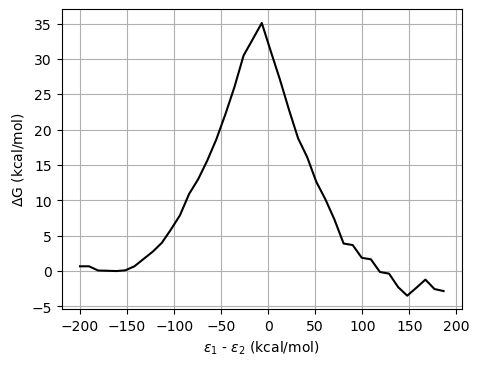

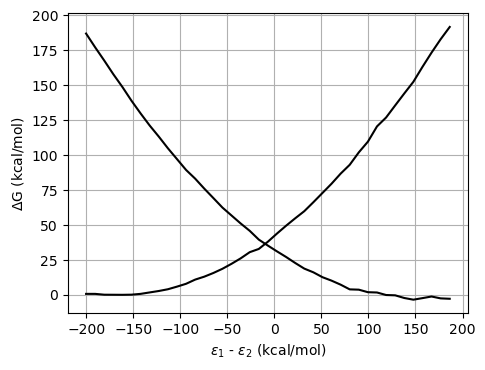

In [36]:
alpha=0
hij=0.8
dl=1/20
kb: float = 1.987204259e-3  # kcal/molK
temp=298.15
bins=50
minpts=5 #minimum of bin count
out='testfep'

joule_to_cal: float = 0.239001



A_xvgs,B_xvgs =fetchA_B_xvgs('potentialA','potentialB')
evbmap(A_xvgs,B_xvgs,alpha,hij,dl,kb,temp,bins,minpts,out)



TS:   34.74,   dG0:   -6.54


(34.74460466585095, -6.5421731227326525)

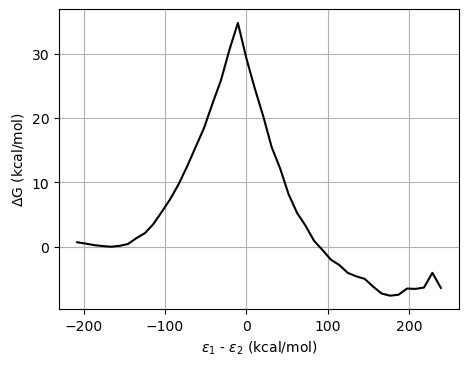

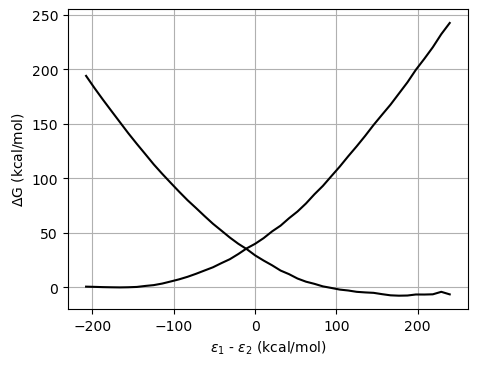

In [37]:
A_xvgs,B_xvgs =fetchA_B_xvgs('potentialA2','potentialB2')
evbmap(A_xvgs,B_xvgs,alpha,hij,dl,kb,temp,bins,minpts,out)

TS:   30.32,   dG0:  -14.11


(30.320487325865624, -14.108502591945594)

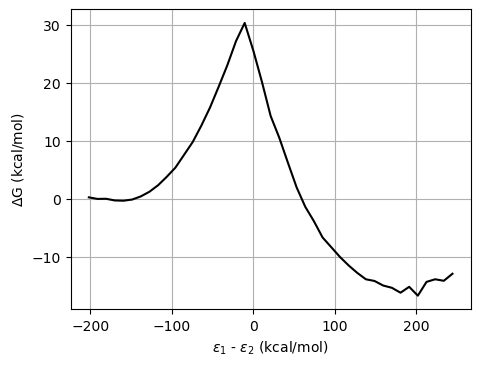

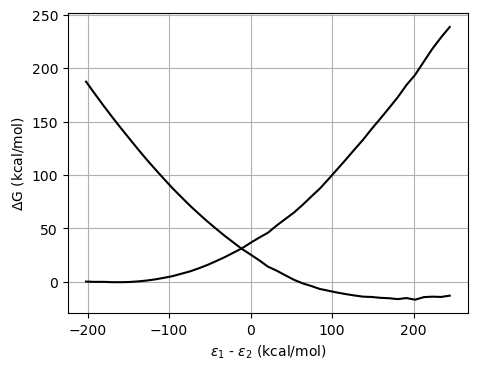

In [38]:
A_xvgs,B_xvgs =fetchA_B_xvgs('potentialAcenter','potentialBcenter')
evbmap(A_xvgs,B_xvgs,alpha,hij,dl,kb,temp,bins,minpts,out)

In [39]:
#txts=glob.glob(
#    os.path.join( "*txt"), recursive=False
#)
#for i in txts:
#    #print(i)
#    os.remove(i)